En primer lugar, la importación de Numpy, Pandas, RegEx y mi archivo de funciones.

In [1]:
import src.funciones as fc
import re
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

Importo el dataset y genero las tablas reducidas con las que voy a trabajar. Me interesan los datos de Australia y Sudáfica para la hipótesis.

In [2]:
data = pd.read_csv("input/GSAF5.csv",encoding='cp1252')
display(data)

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2016.09.18.c,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,16,Minor injury to thigh,N,13h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.c-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.c,2016.09.18.c,5993,NaN,NaN
1,2016.09.18.b,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,Chucky Luciano,M,36,Lacerations to hands,N,11h00,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.b-Luciano.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.b,2016.09.18.b,5992,NaN,NaN
2,2016.09.18.a,18-Sep-16,2016,Unprovoked,USA,Florida,"New Smyrna Beach, Volusia County",Surfing,male,M,43,Lacerations to lower leg,N,10h43,NaN,"Orlando Sentinel, 9/19/2016",2016.09.18.a-NSB.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.18.a,2016.09.18.a,5991,NaN,NaN
3,2016.09.17,17-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Thirteenth Beach,Surfing,Rory Angiolella,M,NaN,Struck by fin on chest & leg,N,NaN,NaN,"The Age, 9/18/2016",2016.09.17-Angiolella.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.17,2016.09.17,5990,NaN,NaN
4,2016.09.15,16-Sep-16,2016,Unprovoked,AUSTRALIA,Victoria,Bells Beach,Surfing,male,M,NaN,No injury: Knocked off board by shark,N,NaN,2 m shark,"The Age, 9/16/2016",2016.09.16-BellsBeach.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2016.09.16,2016.09.15,5989,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5987,ND.0005,Before 1903,0,Unprovoked,AUSTRALIA,Western Australia,Roebuck Bay,Diving,male,M,NaN,FATAL,Y,NaN,NaN,"H. Taunton; N. Bartlett, p. 234",ND-0005-RoebuckBay.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0005,ND.0005,6,NaN,NaN
5988,ND.0004,Before 1903,0,Unprovoked,AUSTRALIA,Western Australia,NaN,Pearl diving,Ahmun,M,NaN,FATAL,Y,NaN,NaN,"H. Taunton; N. Bartlett, pp. 233-234",ND-0004-Ahmun.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0004,ND.0004,5,NaN,NaN
5989,ND.0003,1900-1905,0,Unprovoked,USA,North Carolina,Ocracoke Inlet,Swimming,Coast Guard personnel,M,NaN,FATAL,Y,NaN,NaN,"F. Schwartz, p.23; C. Creswell, GSAF",ND-0003-Ocracoke_1900-1905.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0003,ND.0003,4,NaN,NaN
5990,ND.0002,1883-1889,0,Unprovoked,PANAMA,NaN,"Panama Bay 8ºN, 79ºW",NaN,Jules Patterson,M,NaN,FATAL,Y,NaN,NaN,"The Sun, 10/20/1938",ND-0002-JulesPatterson.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,ND.0002,ND.0002,3,NaN,NaN


In [3]:
australia = data[(data["Country"]== "AUSTRALIA")]
sudafrica = data[(data["Country"]== "SOUTH AFRICA")]
aus = australia[["Date", "Year", "Type", "Activity", "Injury", "Fatal (Y/N)"]].rename(columns={"Fatal (Y/N)": "Fatal"})
sud = sudafrica[["Date", "Year", "Type", "Activity", "Injury", "Fatal (Y/N)"]].rename(columns={"Fatal (Y/N)": "Fatal"})
#Aprovecho para cambiar el nombre de la columna fatal cuando creo las tablas, así trabajaré mejor con ella.

Como voy he generado nuevas tablas (Sudáfrica y Australia), me interesa que tengan su propio índice para poder acceder a los registros.

In [4]:
aus = aus.reset_index(drop=True)
sud = sud.reset_index(drop=True)

Voy a empezar limpiando las tablas para organizar los accidentes por fechas. Quiero ver los años más antiguos para ver desde donde empiezan los registros.

In [5]:
display(aus.groupby('Year').count())
display(sud.groupby('Year').count())

,Date,Type,Activity,Injury,Fatal
Year,,,,,
0,16,16,13,15,16
5,1,1,0,1,1
1788,1,1,1,1,1
1791,1,1,0,1,1
1803,1,1,0,1,1
...,...,...,...,...,...
2012,26,26,25,26,26
2013,20,20,19,20,20
2014,29,29,28,29,29


,Date,Type,Activity,Injury,Fatal
Year,,,,,
0,8,8,8,8,8
1852,2,2,2,2,2
1862,2,2,1,2,2
1863,1,1,1,1,1
1865,1,1,1,1,1
...,...,...,...,...,...
2012,5,5,5,5,5
2013,8,8,8,8,8
2014,5,5,5,5,5


Mirando los datos de los años de Australia, veo que todos los años son coherentes hasta 1788 en los que encuentro 0. 
En el caso de Sudáfrica es por debajo del 1852 cuando encuentro registros con año 0.
Así que voy a utilizar regex para encontrar un año de referencia y voy a asignarle a la columna date un año menos del que encuentre en la descripción. Será un valor aproximado. Después cruzaré los registros de esas columnas con los que en Year tengan año 0.

In [6]:
aus["Date"] = aus["Date"].apply(fc.limpiadate)  
sud["Date"] = sud["Date"].apply(fc.limpiadate)  

Sustituyo los valores 0 de Year por los que hay en la columna Date 

In [7]:
aus.loc[aus['Year'] == 0, "Year"] = aus["Date"]
sud.loc[sud['Year']== 0, "Year"] = sud ["Date"]

Elimino los valores que son 0 porque no he encontrado en "Date" ninguna referencia que asignarles. Para terminar de limpiar los años.

In [8]:
aus = aus.drop(aus[aus['Year']==0].index)
sud = sud.drop(sud[sud['Year']==0].index)
#Hacemos unos print de comprobación con el valor mínimo y  máximo de la columna "Year"
print (f'En Australia el primer año registrado es {min(aus["Year"])} y el último {max(aus["Year"])}')
print (f'En Sudáfrica el primer año registrado es {min(sud["Year"])} y el último {max(sud["Year"])}')

En Australia el primer año registrado es 5 y el último 2016
En Sudáfrica el primer año registrado es 1852 y el último 2016


Ahora, para valorar el nivel de agresividad de los tiburones, voy a crear una nueva columna llamada "Score", donde puntuaré los ataques del 1 al 3. 
Los ataques fatales tendrán directamente la puntuación máxima. Después valoraré con 1 a los que la columna "Injury" devuelva "sin daños" o "laceraciones" y 2 al resto de casos.
Creo las columnas y les paso una fórmula que sustituye "Y" por valor 3.

In [9]:
aus['Score'] = aus['Fatal']
sud['Score'] = sud['Fatal']
aus["Score"] = aus["Score"].apply(fc.assignscore3)  
sud["Score"] = sud["Score"].apply(fc.assignscore3)

In [10]:
display(aus, sud)

,Date,Year,Type,Activity,Injury,Fatal,Score
0,0,2016,Unprovoked,Surfing,Struck by fin on chest & leg,N,N
1,0,2016,Unprovoked,Surfing,No injury: Knocked off board by shark,N,N
2,0,2016,Boat,Fishing,Shark rammed boat. No injury to occupant,N,N
3,0,2016,Unprovoked,Surfing,"No inury, board broken in half by shark",N,N
4,0,2016,Boat,Kayaking,"No injury, shark nudged kayak repeatedly",N,N
...,...,...,...,...,...,...,...
1274,1905,1905,Unprovoked,Fishing,FATAL,Y,3
1275,1905,1905,Unprovoked,Fishing,FATAL,Y,3
1276,1905,1905,Unprovoked,Swimming,FATAL,Y,3
1277,1902,1902,Unprovoked,Diving,FATAL,Y,3


,Date,Year,Type,Activity,Injury,Fatal,Score
0,0,2016,Unprovoked,Spearfishing,Injuries to left leg & right hand,N,N
1,0,2016,Unprovoked,Surf-skiing,"No injury, surf-ski bitten",N,N
2,0,2016,Boat,Kayak fishing,"No injury, shark capsized kayak",N,N
3,0,2015,Boat,Kayak Fishing,"No injury, kayak damaged",N,N
4,0,2015,Unprovoked,Swimming / Wading,Lacerations to both hands and forearms,N,N
...,...,...,...,...,...,...,...
558,1966,1966,Unprovoked,Crossing river on a raft,"FATAL, leg severed",Y,3
561,1920,1920,Unprovoked,Crew swimming alongside their anchored ship,FATAL,Y,3
562,1920,1920,Unprovoked,4 men were bathing,FATAL,Y,3
563,1912,1912,Unprovoked,Fishing,"FATAL, body not recovered but shark was caught...",Y,3


Ahora toca trabajar con la columna "Injury" para poder asignar el resto de puntuaciones.
Considero todo lo que es "minor" y "laceraciones" como ataque de agresividad bajo (1)
Considero todo lo que es "fatal" como agresividad alta (3)
Todo lo que queda, se le asigna un valor medio (2) normalmente mordeduras, miembros y algunas filas "sin datos"

In [12]:
aus["Injury"] = aus["Injury"].apply(fc.assingscore)  
sud["Injury"] = sud["Injury"].apply(fc.assingscore)

Igualamos los valores asignados a las lesiones en la columna "Score" para los que no tienen un valor asignado aún.

In [13]:
aus.loc[aus['Score'] != "3", "Score"] = aus["Injury"]
sud.loc[sud['Score'] != "3", "Score"] = sud["Injury"]

Convierto los valores de la columna "Score" en enteros

In [15]:
aus["Score"] = aus["Score"].apply(fc.casteascore)  
sud["Score"] = sud["Score"].apply(fc.casteascore)

Divido los años por décadas. Sumando los registros que hay por cada año y haciendo la media del "Score" para ver la agresividad en comparación con la década.

In [53]:
sud["Decadas"] = pd.cut(sud.Year,bins=[1939,1949,1959,1969,1979,1989,1999,2009,2019], labels=range(1940,2020,10))

In [54]:
aus["Decadas"] = pd.cut(aus.Year,bins=[1939,1949,1959,1969,1979,1989,1999,2009,2019], labels=range(1940,2020,10))

Sudáfrica AxesSubplot(0.125,0.125;0.775x0.755) Australia AxesSubplot(0.125,0.125;0.775x0.755)


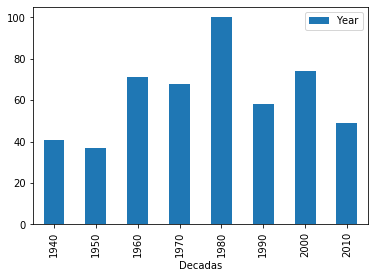

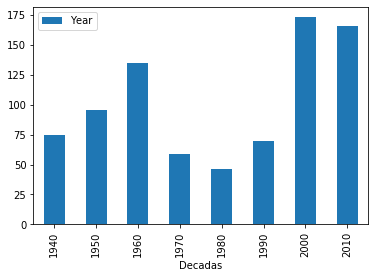

In [55]:
print("Sudáfrica", sud.groupby("Decadas").agg({"Year":"count"}).plot.bar(), "Australia",aus.groupby("Decadas").agg({"Year":"count"}).plot.bar())

,Year,Score
Decadas,,
1940,75,1.800000
1950,96,1.718750
1960,135,1.570370
1970,59,1.966102
1980,46,1.847826
1990,70,1.671429
2000,173,1.502890
2010,166,1.506024


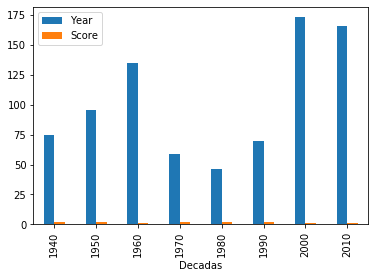

In [57]:
%matplotlib inline
a = aus.groupby("Decadas").agg({
    "Year": "count",
        "Score":"mean"
})
a.plot.bar()
display(a)